In [9]:
import requests
from PIL import Image
import torch
from datasets import load_dataset
import evaluate
from transformers import BlipProcessor, BlipForConditionalGeneration

# --- 1. Setup evaluation metrics ---
bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [22]:
from evaluate import load

bleu = load("bleu")
meteor = load("meteor")
rouge = load("rouge")

# 生成的 caption
prediction = ["a man standing in the grass"]

# 參考 caption（多個給 BLEU，用一個給 METEOR 和 ROUGE）
references_bleu = [["Two young guys with shaggy hair look at their hands while hanging out in the yard."]]
references_single = ["Two young guys with shaggy hair look at their hands while hanging out in the yard."]

# 計算 BLEU
bleu_score = bleu.compute(predictions=prediction, references=references_bleu)
print(f"BLEU score: {bleu_score['bleu']}")

# 計算 METEOR
meteor_score = meteor.compute(predictions=prediction, references=references_single)
print(f"METEOR score: {meteor_score}")

# 計算 ROUGE
rouge_score = rouge.compute(predictions=prediction, references=references_single)
print(f"ROUGE score: {rouge_score}")


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU score: 0.0
METEOR score: {'meteor': np.float64(0.1179245283018868)}
ROUGE score: {'rouge1': np.float64(0.18181818181818182), 'rouge2': np.float64(0.1), 'rougeL': np.float64(0.18181818181818182), 'rougeLsum': np.float64(0.18181818181818182)}


# BLIP+MSCOCO

In [ ]:

# --- 2. Load BLIP model and processor ---
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

# --- 3. Load a subset of the MSCOCO dataset ---
# Here we use the MSCOCO 5K test set for image-text retrieval.
# (If you want a different split, adjust the dataset name or split accordingly.)
mscocods = load_dataset("nlphuji/mscoco_2014_5k_test_image_text_retrieval", split="test")
print(mscocods)

# --- 4. Loop over the dataset to generate predictions ---
predictions = []
references = []

print("Processing images and generating captions...")

for i, sample in enumerate(mscocods):
    # Get image from the sample
    image = sample["image"]
    
    # Retrieve a reference caption.
    # Some datasets store this under "caption" or "captions"; adjust if needed.
    if "caption" in sample:
        ref = sample["caption"]
    elif "captions" in sample:
        # If multiple references are provided, we use the first one.
        ref = sample["captions"][0]
    else:
        ref = ""
    references.append(ref)
    
    # Process the image for BLIP.
    inputs = processor(image, return_tensors="pt").to("cuda")
    
    # Generate the caption.
    with torch.no_grad():
        out = model.generate(**inputs)
    pred_caption = processor.decode(out[0], skip_special_tokens=True)
    predictions.append(pred_caption)
    
    if i % 1000 == 0:
        print(f"Processed {i} samples...")

# --- 5. Compute evaluation metrics ---
# BLEU expects each reference to be a list of one or more reference sentences.
BLIP_MScoco_bleu_score = bleu_metric.compute(predictions=predictions, references=[[ref] for ref in references])["bleu"]
BLIP_MScoco_meteor_score = meteor_metric.compute(predictions=predictions, references=references)["meteor"]
BLIP_MScoco_rouge_score = rouge_metric.compute(predictions=predictions, references=references)

print("\n--- Evaluation Metrics ---")
print("BLEU Score:  ", BLIP_MScoco_bleu_score)
print("METEOR Score:", BLIP_MScoco_meteor_score)
print("ROUGE Score: ", BLIP_MScoco_rouge_score)


BLIP_MScoco_performance = [BLIP_MScoco_bleu_score, BLIP_MScoco_rouge_score['rouge1'], BLIP_MScoco_rouge_score['rouge2'], BLIP_MScoco_rouge_score['rougeL'], BLIP_MScoco_meteor_score]


/home/labstudent/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_f

Dataset({
    features: ['image', 'caption', 'sentids', 'imgid', 'split', 'cocoid', 'filename', 'filepath', 'tokens', 'sentid'],
    num_rows: 5000
})
Processing images and generating captions...
Processed 0 samples...
Processed 1000 samples...
Processed 2000 samples...
Processed 3000 samples...
Processed 4000 samples...

--- Evaluation Metrics ---
BLEU Score:   9.962681302824863e-05
METEOR Score: 0.4206737619036443
ROUGE Score:  {'rouge1': np.float64(0.5686198850075579), 'rouge2': np.float64(0.335045725052283), 'rougeL': np.float64(0.5392895455530919), 'rougeLsum': np.float64(0.539292615359741)}


In [13]:
# save in csv
import csv
with open('BLIP_MScoco_performance.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['BLEU', 'ROUGE1', 'ROUGE2', 'ROUGEL', 'METEOR'])
    writer.writerow([BLIP_MScoco_bleu_score, BLIP_MScoco_rouge_score['rouge1'], BLIP_MScoco_rouge_score['rouge2'], BLIP_MScoco_rouge_score['rougeL'], BLIP_MScoco_meteor_score]
)

# BLIP+FLICKR

In [ ]:
import requests
from PIL import Image
import torch
from datasets import load_dataset
import evaluate
from transformers import BlipProcessor, BlipForConditionalGeneration


# --- 3. Load a subset of the MSCOCO dataset ---
# Here we use the MSCOCO 5K test set for image-text retrieval.
# (If you want a different split, adjust the dataset name or split accordingly.)
flickrds = load_dataset("nlphuji/flickr30k", split="test")
print(flickrds)

# --- 4. Loop over the dataset to generate predictions ---
predictions = []
references = []

print("Processing images and generating captions...")

for i, sample in enumerate(flickrds):
    # Get image from the sample
    image = sample["image"]
    
    # Retrieve a reference caption.
    # Some datasets store this under "caption" or "captions"; adjust if needed.
    if "caption" in sample:
        ref = sample["caption"]
    elif "captions" in sample:
        # If multiple references are provided, we use the first one.
        ref = sample["captions"][0]
    else:
        ref = ""
    references.append(ref)
    
    # Process the image for BLIP.
    inputs = processor(image, return_tensors="pt").to("cuda")
    
    # Generate the caption.
    with torch.no_grad():
        out = model.generate(**inputs)
    pred_caption = processor.decode(out[0], skip_special_tokens=True)
    predictions.append(pred_caption)
    
    if i % 1000 == 0:
        print(f"Processed {i} samples...")

# --- 5. Compute evaluation metrics ---
# BLEU expects each reference to be a list of one or more reference sentences.
BLIP_flickr_bleu_score = bleu_metric.compute(predictions=predictions, references=[[ref] for ref in references])["bleu"]
BLIP_flickr_meteor_score = meteor_metric.compute(predictions=predictions, references=references)["meteor"]
BLIP_flickr_rouge_score = rouge_metric.compute(predictions=predictions, references=references)

print("\n--- Evaluation Metrics ---")
print("BLEU Score:  ", BLIP_flickr_bleu_score)
print("METEOR Score:", BLIP_flickr_meteor_score)
print("ROUGE Score: ", BLIP_flickr_rouge_score)


Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 31014
})
Processing images and generating captions...
Processed 0 samples...
Processed 1000 samples...
Processed 2000 samples...
Processed 3000 samples...
Processed 4000 samples...
Processed 5000 samples...
Processed 6000 samples...
Processed 7000 samples...
Processed 8000 samples...
Processed 9000 samples...
Processed 10000 samples...
Processed 11000 samples...
Processed 12000 samples...
Processed 13000 samples...
Processed 14000 samples...
Processed 15000 samples...
Processed 16000 samples...
Processed 17000 samples...
Processed 18000 samples...
Processed 19000 samples...
Processed 20000 samples...
Processed 21000 samples...
Processed 22000 samples...
Processed 23000 samples...
Processed 24000 samples...
Processed 25000 samples...
Processed 26000 samples...
Processed 27000 samples...
Processed 28000 samples...
Processed 29000 samples...
Processed 30000 samples...
Processed 31000 samp

In [14]:
# save in csv
import csv
with open('BLIP_flickr_performance.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['BLEU', 'ROUGE1', 'ROUGE2', 'ROUGEL', 'METEOR'])
    writer.writerow([BLIP_flickr_bleu_score, BLIP_flickr_rouge_score['rouge1'], BLIP_flickr_rouge_score['rouge2'], BLIP_flickr_rouge_score['rougeL'], BLIP_flickr_meteor_score])

# Phi+MSCOCO

In [1]:
import torch
from PIL import Image
from datasets import load_dataset
import evaluate
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig

mscocods = load_dataset("nlphuji/mscoco_2014_5k_test_image_text_retrieval", split="test")
print(mscocods)

# --- 2. Load Phi-4 multimodal model and processor ---
model_id = "microsoft/Phi-4-multimodal-instruct"
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    device_map="cuda",
    torch_dtype="auto",
    _attn_implementation="flash_attention_2"
).to("cuda")

# Set generation config
generation_config = GenerationConfig.from_pretrained(model_id)
generation_config.max_new_tokens = 100
generation_config.num_logits_to_keep = 100
generation_config.do_sample = False
generation_config.temperature = 0.9

# --- 3. Load MSCOCO dataset subset ---

# --- 4. Generate predictions using Phi-4 ---
user_prompt = "<|user|>"
assistant_prompt = "<|assistant|>"
prompt_suffix = "<|end|>"

predictions = []
references = []

print("Generating captions using Phi-4...")

/home/labstudent/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['image', 'caption', 'sentids', 'imgid', 'split', 'cocoid', 'filename', 'filepath', 'tokens', 'sentid'],
    num_rows: 5000
})


/home/labstudent/.local/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/labstudent/.cache/huggingface/modules/transformers_modules/microsoft/Phi-4-multimodal-instruct/49434512b7724a18ba0631ca296ed4dfbd9e29c9/speech_conformer_encoder.py:2774: FutureWarning: Please specify CheckpointImpl.NO_REENTRANT as CheckpointImpl.REENTRANT will soon be removed as the default and eventually deprecated.
  lambda i: encoder_checkpoint_wrapper(
Loading che

Generating captions using Phi-4...


In [ ]:
for i, sample in enumerate(mscocods):
    image = sample["image"]
    ref = sample.get("caption", sample.get("captions", [""]))[0]
    references.append(ref)

    prompt = f"{user_prompt}<|image_1|>What is shown in this image?{prompt_suffix}{assistant_prompt}"
    
    # Prepare model input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda")

    # Generate caption
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            num_logits_to_keep=generation_config.num_logits_to_keep,
            max_new_tokens=generation_config.max_new_tokens,
            generation_config=generation_config
        )

    # Remove the prompt tokens from output
    outputs = outputs[:, inputs["input_ids"].shape[1]:]
    pred_caption = processor.batch_decode(outputs, skip_special_tokens=True)[0]
    predictions.append(pred_caption)

    if i % 1000 == 0:
        print(f"Processed {i} samples...")
  

/home/labstudent/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Processed 0 samples...
Processed 1000 samples...
Processed 2000 samples...
Processed 3000 samples...
Processed 4000 samples...


NameError: name 'bleu_metric' is not defined

In [4]:
      
# --- 5. Evaluate metrics ---
Phi_MScoco_bleu_score = bleu_metric.compute(predictions=predictions, references=[[r] for r in references])["bleu"]
Phi_MScoco_meteor_score = meteor_metric.compute(predictions=predictions, references=references)["meteor"]
Phi_MScoco_rouge_score = rouge_metric.compute(predictions=predictions, references=references)

print("\n--- Evaluation Metrics ---")
print("BLEU Score:  ", Phi_MScoco_bleu_score)
print("METEOR Score:", Phi_MScoco_meteor_score)
print("ROUGE-1:     ", Phi_MScoco_rouge_score["rouge1"])
print("ROUGE-2:     ", Phi_MScoco_rouge_score["rouge2"])

Phi_MScoco_performance = [Phi_MScoco_bleu_score, Phi_MScoco_rouge_score['rouge1'], Phi_MScoco_rouge_score['rouge2'], Phi_MScoco_rouge_score['rougeL'], Phi_MScoco_meteor_score]



--- Evaluation Metrics ---
BLEU Score:   0.015116822778650583
METEOR Score: 0.25142590642826346
ROUGE-1:      0.17017456058708708
ROUGE-2:      0.05879485946190327


In [5]:
# save in csv
import csv

with open('Phi_MScoco_performance.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['BLEU', 'ROUGE1', 'ROUGE2', 'ROUGEL', 'METEOR'])
    writer.writerow([Phi_MScoco_bleu_score, Phi_MScoco_rouge_score['rouge1'], Phi_MScoco_rouge_score['rouge2'], Phi_MScoco_rouge_score['rougeL'], Phi_MScoco_meteor_score])

# Phi+FLICKR

In [1]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import evaluate
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = "cuda"

# Load metrics
bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")
model_id = "microsoft/Phi-4-multimodal-instruct"

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16, 
    device_map="auto",
    trust_remote_code=True,
).to(device)
model.eval()

generation_config = GenerationConfig(max_new_tokens=20)

# Load dataset
flickrds = load_dataset("nlphuji/flickr30k", split="test")

# DataLoader for batching
def collate_fn(samples):
    images = [s["image"] for s in samples]
    refs = [s.get("caption", s.get("captions", [""]))[0] for s in samples]
    return images, refs

batch_size = 16  # Adjust based on GPU memory
dataloader = DataLoader(flickrds, batch_size=batch_size, collate_fn=collate_fn, num_workers=4)

predictions, references = [], []

prompt_template = "<|user|><|image_1|>What is shown in this image?<|end|><|assistant|>"

with torch.no_grad():
    for images, refs in tqdm(dataloader, desc="Generating Captions"):
        inputs = processor(
            text=[prompt_template] * len(images), 
            images=images, 
            return_tensors="pt", 
            padding=True
        ).to(device)

        outputs = model.generate(**inputs, generation_config=generation_config)

        # Remove prompt tokens from output
        outputs = outputs[:, inputs["input_ids"].shape[1]:]
        captions = processor.batch_decode(outputs, skip_special_tokens=True)

        predictions.extend(captions)
        references.extend(refs)

# Evaluation
bleu = bleu_metric.compute(predictions=predictions, references=[[r] for r in references])["bleu"]
meteor = meteor_metric.compute(predictions=predictions, references=references)["meteor"]
rouge = rouge_metric.compute(predictions=predictions, references=references)

print("\n--- Evaluation Metrics ---")
print(f"BLEU Score:   {bleu:.4f}")
print(f"METEOR Score: {meteor:.4f}")
print(f"ROUGE-1:      {rouge['rouge1']:.4f}")
print(f"ROUGE-2:      {rouge['rouge2']:.4f}")
print(f"ROUGE-L:      {rouge['rougeL']:.4f}")

Phi_MScoco_performance = [bleu, rouge['rouge1'], rouge['rouge2'], rouge['rougeL'], meteor]


/home/labstudent/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/labstudent/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/home/labstudent/.local/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow


--- Evaluation Metrics ---
BLEU Score:   0.0454
METEOR Score: 0.2510
ROUGE-1:      0.3284
ROUGE-2:      0.0928
ROUGE-L:      0.2567


In [2]:
# save in csv
import csv

with open('Phi_flickr_performance.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['BLEU', 'ROUGE1', 'ROUGE2', 'ROUGEL', 'METEOR'])
    writer.writerow([bleu, rouge['rouge1'], rouge['rouge2'], rouge['rougeL'], meteor])

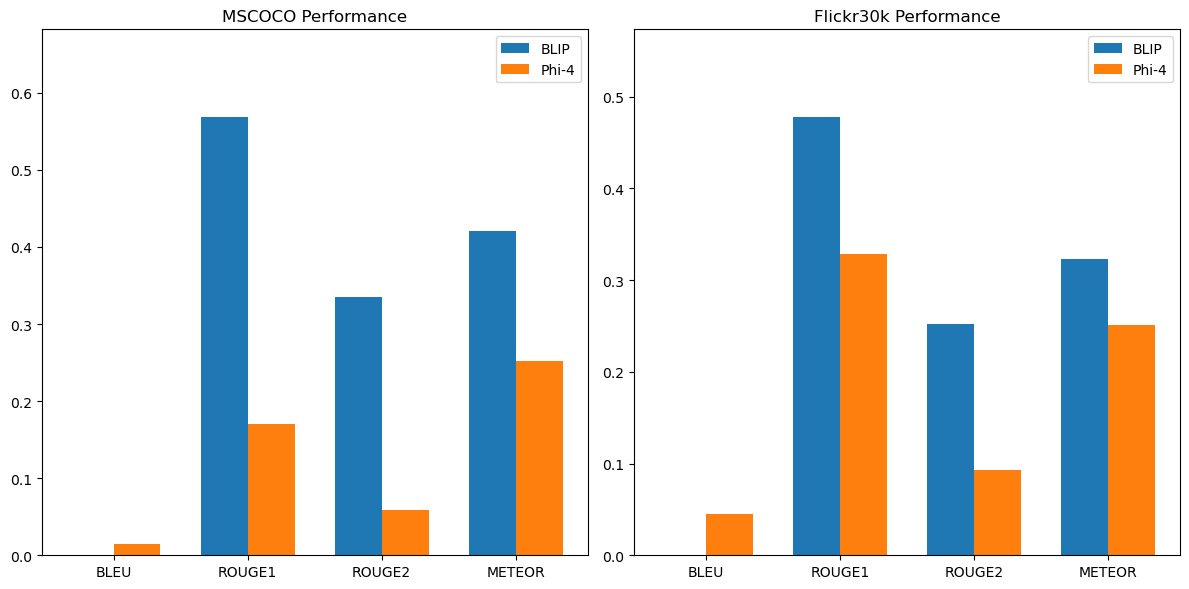

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the performance metrics
blip_mscoco = pd.read_csv("BLIP_MScoco_performance.csv")
blip_flickr = pd.read_csv("BLIP_flickr_performance.csv")
phi_mscoco = pd.read_csv("Phi_MScoco_performance.csv")
phi_flickr = pd.read_csv("Phi_flickr_performance.csv")

# Extract values
metrics = ['BLEU', 'ROUGE1', 'ROUGE2', 'METEOR']

blip_mscoco_vals = blip_mscoco.loc[0, metrics].values
phi_mscoco_vals = phi_mscoco.loc[0, metrics].values

blip_flickr_vals = blip_flickr.loc[0, metrics].values
phi_flickr_vals = phi_flickr.loc[0, metrics].values

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
x = range(len(metrics))

# MSCOCO
ax[0].bar(x, blip_mscoco_vals, width=0.35, label='BLIP', align='center')
ax[0].bar([i + 0.35 for i in x], phi_mscoco_vals, width=0.35, label='Phi-4', align='center')
ax[0].set_title("MSCOCO Performance")
ax[0].set_xticks([i + 0.175 for i in x])
ax[0].set_xticklabels(metrics)
ax[0].legend()
ax[0].set_ylim(0, max(blip_mscoco_vals.max(), phi_mscoco_vals.max()) * 1.2)

# Flickr30k
ax[1].bar(x, blip_flickr_vals, width=0.35, label='BLIP', align='center')
ax[1].bar([i + 0.35 for i in x], phi_flickr_vals, width=0.35, label='Phi-4', align='center')
ax[1].set_title("Flickr30k Performance")
ax[1].set_xticks([i + 0.175 for i in x])
ax[1].set_xticklabels(metrics)
ax[1].legend()
ax[1].set_ylim(0, max(blip_flickr_vals.max(), phi_flickr_vals.max()) * 1.2)

plt.tight_layout()
plt.show()
